In [1]:
import os
import torch
from torch import nn
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# Set fixed random number seed
torch.manual_seed(42)

# Dataset Manipulation

The first thing we need to do is <font color=DeepPink>**load the dataset**</font>. 

This will automatically download the training set for the **CIFAR10** dataset and save it in a folder called `data`. It will create the folder if it does not exist.

We transform them to Tensors of normalized range [-1, 1].

In [3]:
# Hyperparameters
dataroot = 'data'
batch_size = 256

# load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = CIFAR10(dataroot, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_data = CIFAR10(dataroot, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# Neural Network

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. 

Specifically, first we will flatten our 3x32x32 (3 color channel, 32 pixels height and width) image into a 3072 element vector, also called 3072 features. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 3072 dimensional input is passed through the first hidden layer to transform it into 1024 dimensions. Then, another hidden layer, which will transform it to 512 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten categories, so need our output to be 10 dimensions.

```torch.nn.Linear()``` applies a linear transformation to the incoming data: $ y = xW^T+b $

Example: the input tensor ```x.shape=[10, 3072]```, where 10 is the batch size. We set two parameters of ```torch.nn.Linear()``` are 3072 and 1024, which means that ```W.shape=[1024, 3072]```, so the shape of $ W^T $ is ```W^T.shape=[3072, 1024]``` and the shape of $ b $ is ```b.shape=[1024]```. Using the formula, we can get $ y $ with the shape ```y.shape=[10, 1024]```.

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 256),
            nn.Sigmoid(),
            nn.Linear(256, 256),
            nn.Sigmoid(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

In [5]:
input_dim = 32 * 32 * 3
output_dim = 10
model = Net(input_dim, output_dim)
print(model)

Net(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=256, out_features=10, bias=True)
    (12): Sigmoid()
  )
)


This small function is created to calculate the number of trainable parameters (weights and biases) in MLP.

```torch.numel()``` returns the number of all elements in a tensor variable.

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,937,034 trainable parameters


In [8]:
cache_layers1_w = []
cache_layers3_w = []
cache_layers5_w = []
cache_layers7_w = []
cache_layers9_w = []
cache_layers11_w = []

for item in model.named_parameters():
    if item[0] == 'layers.1.weight':
        item[1].register_hook(lambda grad: cache_layers1_w.append(torch.mean(grad).item()))
    elif item[0] == 'layers.3.weight':
        item[1].register_hook(lambda grad: cache_layers3_w.append(torch.mean(grad).item()))
    elif item[0] == 'layers.5.weight':
        item[1].register_hook(lambda grad: cache_layers5_w.append(torch.mean(grad).item()))
    elif item[0] == 'layers.7.weight':
        item[1].register_hook(lambda grad: cache_layers7_w.append(torch.mean(grad).item()))
    elif item[0] == 'layers.9.weight':
        item[1].register_hook(lambda grad: cache_layers9_w.append(torch.mean(grad).item()))
    elif item[0] == 'layers.11.weight':
        item[1].register_hook(lambda grad: cache_layers11_w.append(torch.mean(grad).item()))
#给指定层的 .weight 张量挂上一个“回调函数”——每当该层算出梯度时，PyTorch 会自动调用这个函数，把这一层权重张量里所有元素梯度的平均值塞进对应的列表里。
#因此 cache_layers*_w 会在训练过程中动态累积这些层的平均梯度值，方便监控梯度情况。

# Train

In [9]:
criterion = nn.CrossEntropyLoss() # define a loss function

In [10]:
# Hyperparameters
lr = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=lr) # define a optimizer

In [11]:
def train(trainloader, model, criterion, optimizer, device):
    # switch to train mode
    model.train()

    epoch_loss = []
    epoch_acc = []
    
    for i, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)

        # Forward pass
        output = model(image)

        # Compute loss
        loss = criterion(output, label)

        # measure accuracy
        acc = accuracy(output, label)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())

    return sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)



# Test

In [12]:
def test(testloader, model, device):
    # switch to evaluate mode
    model.eval()

    epoch_acc = []

    with torch.no_grad():
        for i, (image, label) in enumerate(testloader):
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            
            acc = accuracy(output, label)
            
            epoch_acc.append(acc.item())

    return sum(epoch_acc) / len(epoch_acc)
            

            


# Evaluation

In [13]:
def accuracy(output, target):
    with torch.no_grad():
        pred = output.argmax(dim=1)
        return (pred == target).float().mean() * 100

# Plot

In [14]:
def plot_grad(l1, l3, l5, l7, l9, l11):
    plot_x = np.arange(len(l1))
    plt.figure(figsize=(15, 7))

    plt.plot(plot_x, l1)
    plt.plot(plot_x, l3)
    plt.plot(plot_x, l5)
    plt.plot(plot_x, l7)
    plt.plot(plot_x, l9)
    plt.plot(plot_x, l11)

    plt.xlabel('Iteration')
    plt.ylabel('Gradient')
    plt.legend(['layers1.weight', 'layers3.weight', 'layers5.weight', 'layers7.weight', 'layers9.weight', 'layers11.weight'])
    plt.show()


In [15]:
def plot_one_grad(grad, name):
    plot_x = np.arange(len(grad))
    plt.figure(figsize=(15, 7))

    plt.plot(plot_x, grad)

    plt.xlabel('Iteration')
    plt.ylabel('Gradient')
    plt.legend([name])
    plt.show()


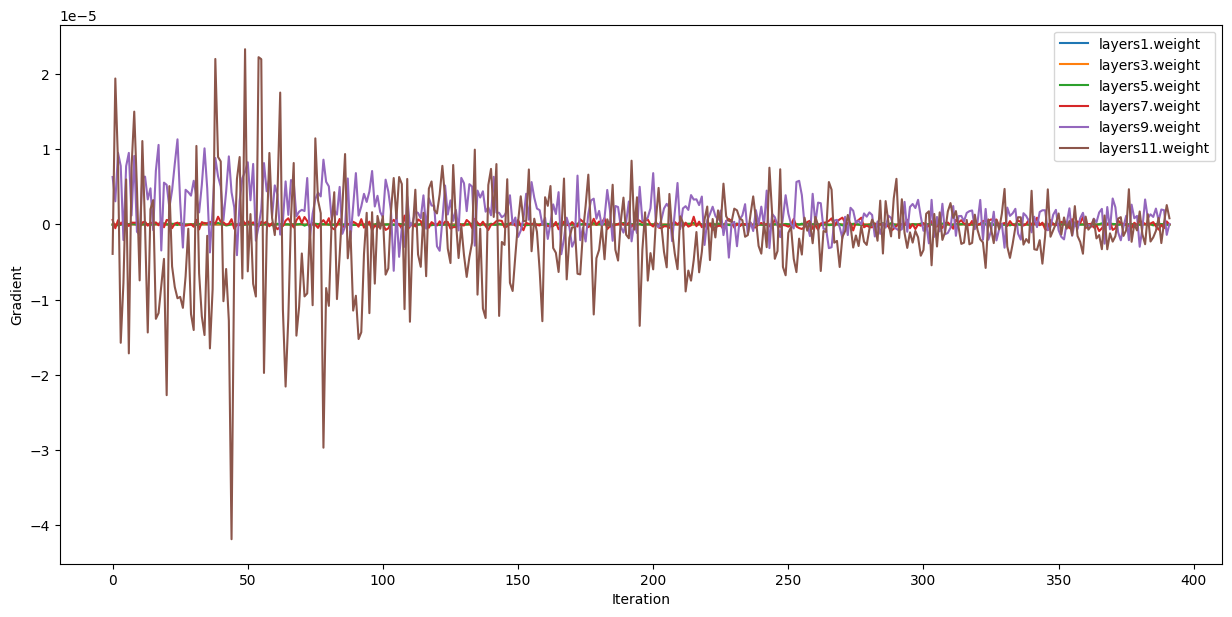

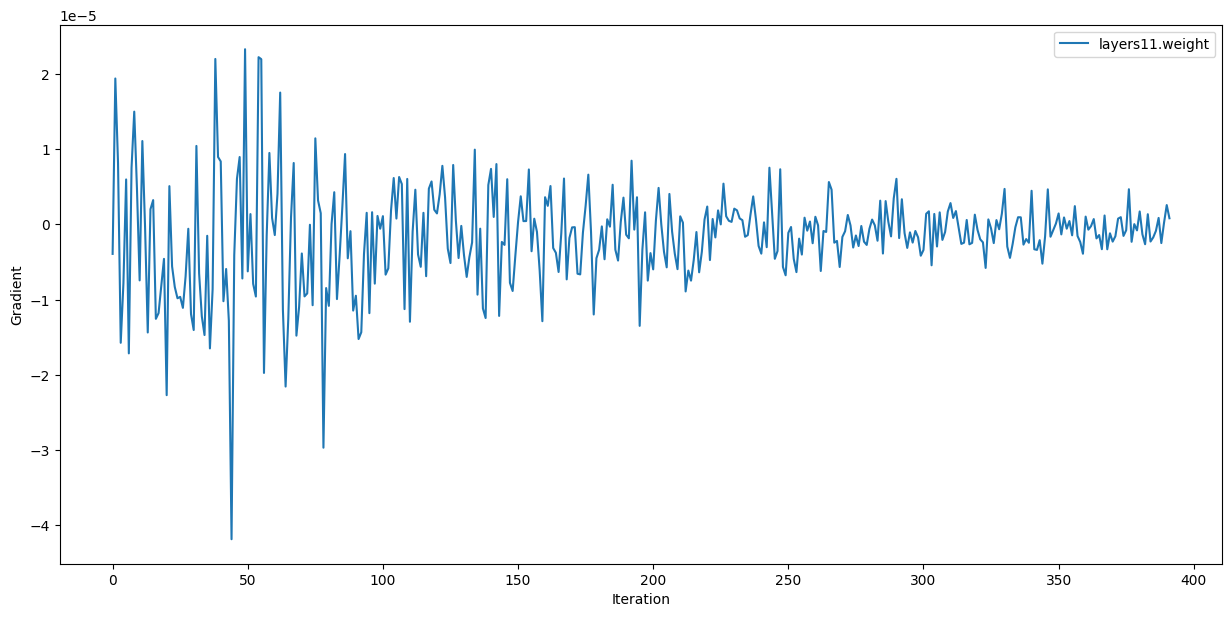

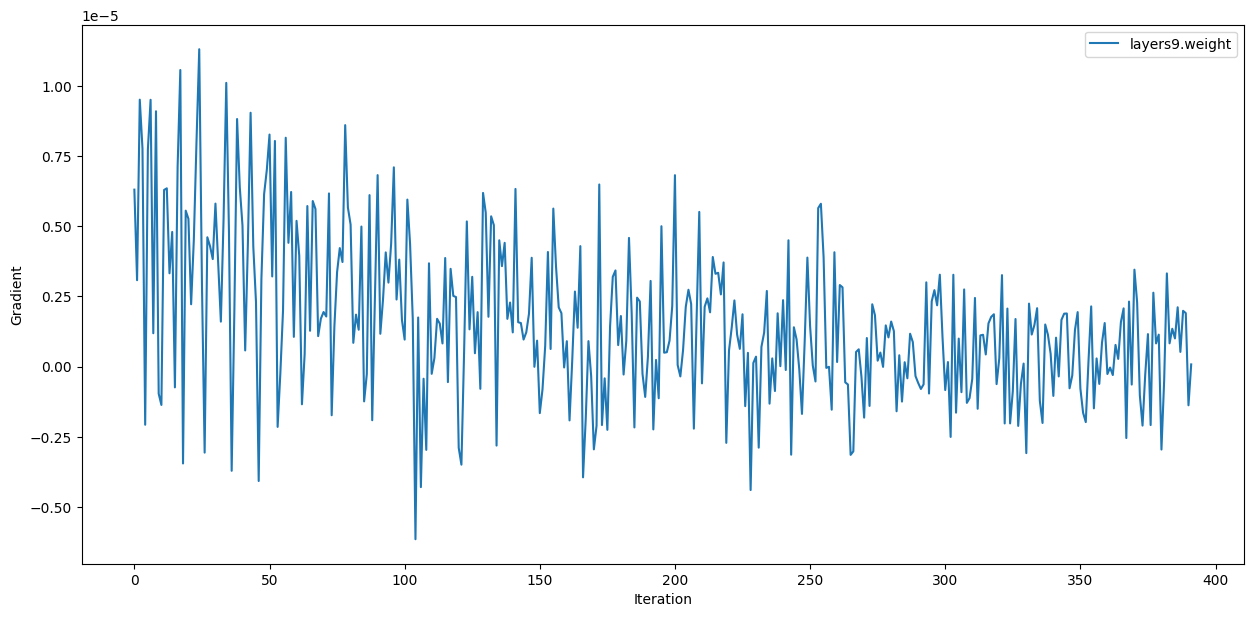

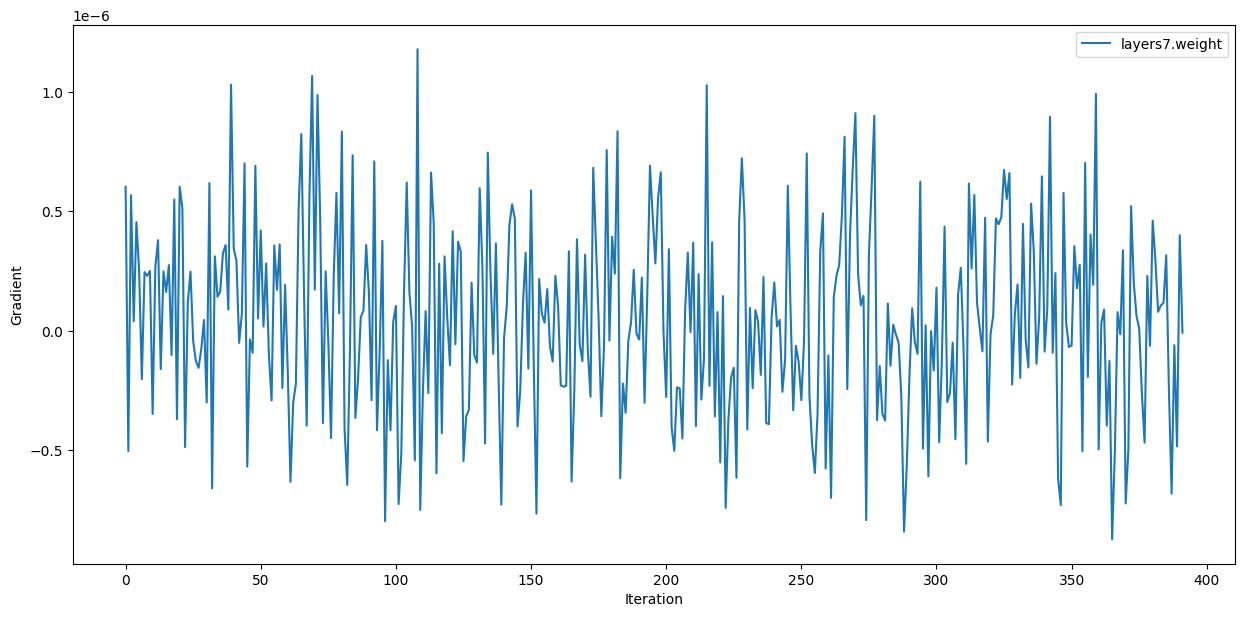

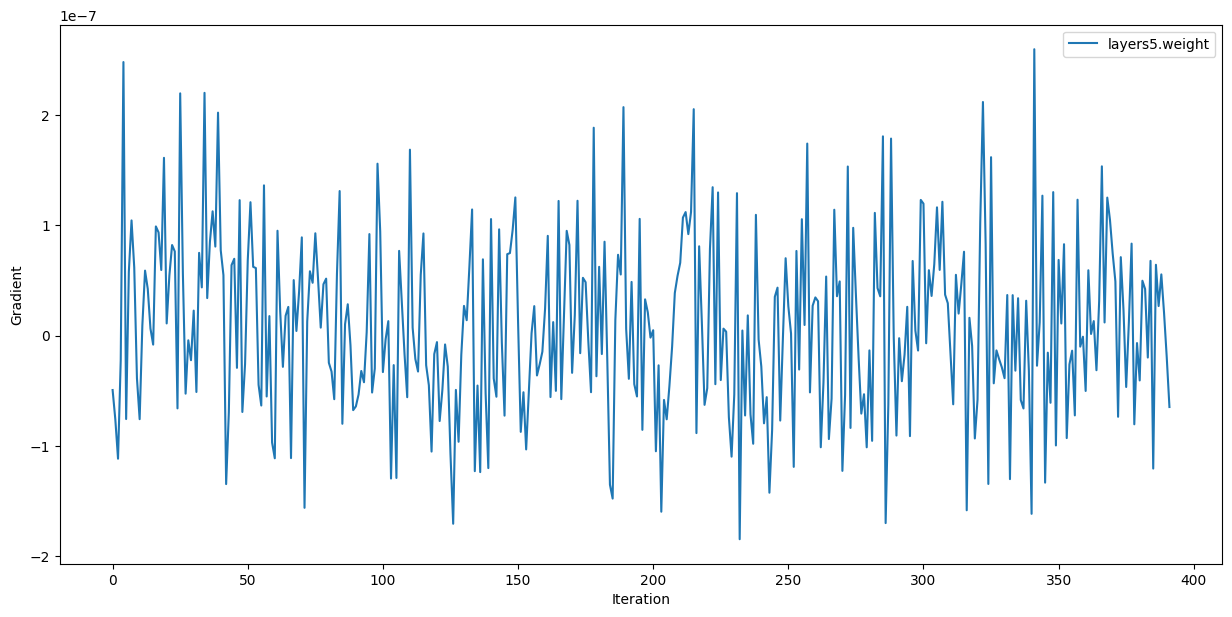

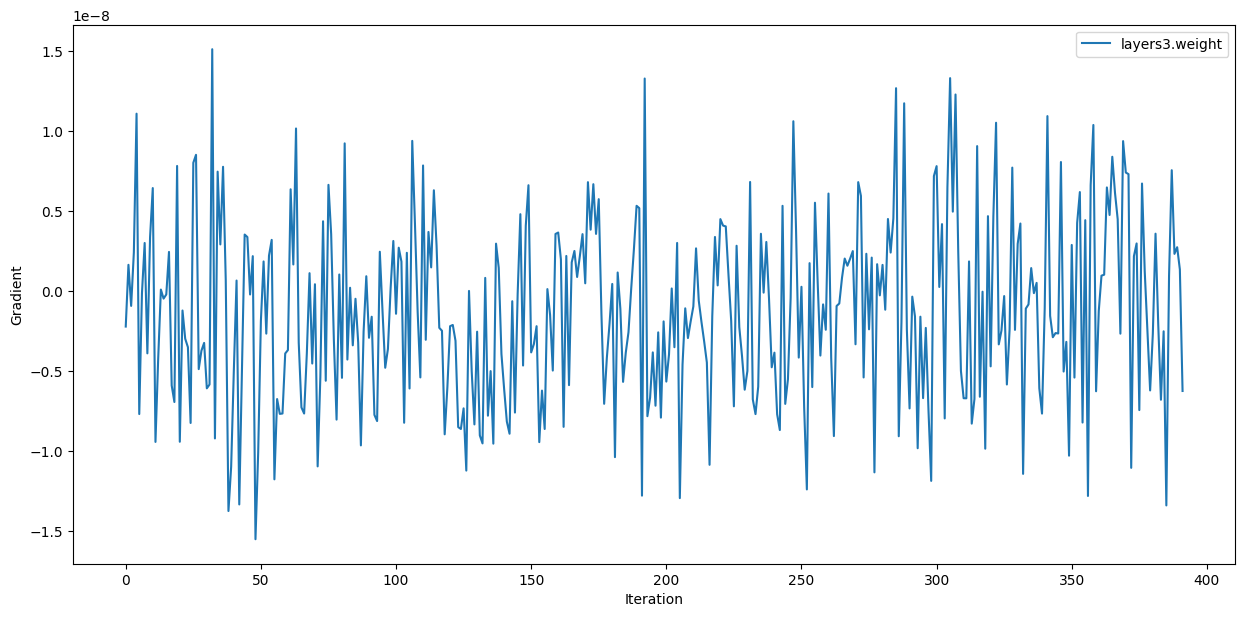

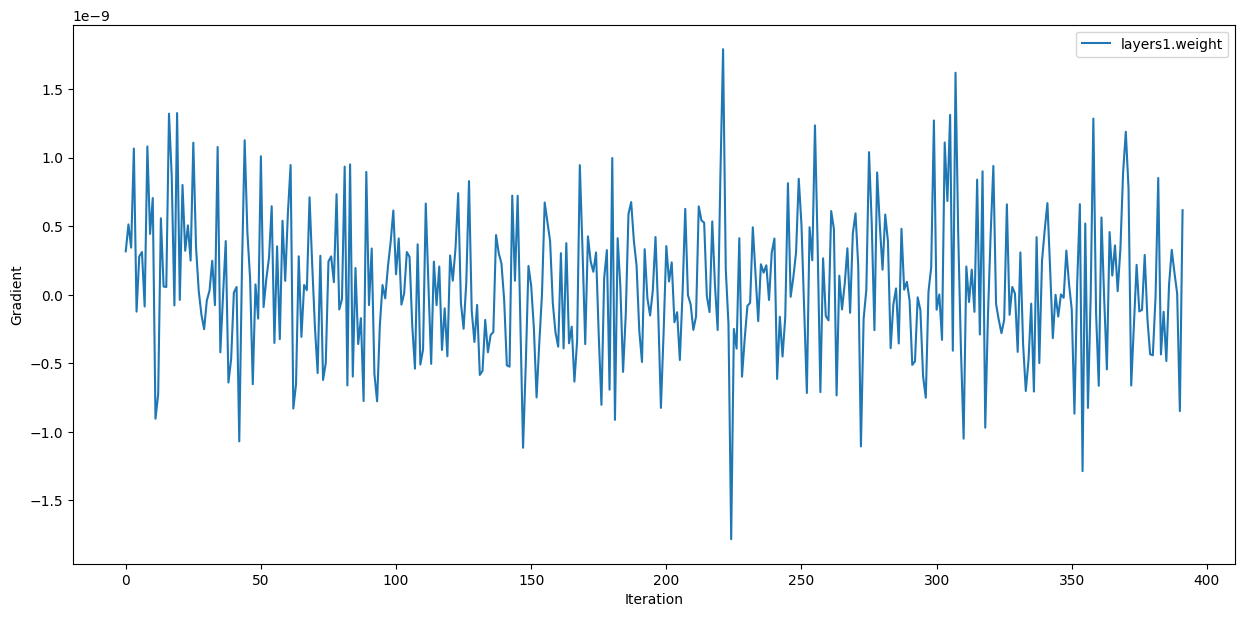

In [16]:
n_epoch = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# place mlp and criterion on to the device
model = model.to(device)
criterion = criterion.to(device)

train_loss = []
train_acc = []
test_acc = []

for epoch in range(n_epoch):
    train_epoch_loss, train_epoch_acc = train(trainloader, model, criterion, optimizer, device)
    test_epoch_acc = test(testloader, model, device)

plot_grad(cache_layers1_w, cache_layers3_w, cache_layers5_w, cache_layers7_w, cache_layers9_w, cache_layers11_w)
plot_one_grad(cache_layers11_w, 'layers11.weight')
plot_one_grad(cache_layers9_w, 'layers9.weight')
plot_one_grad(cache_layers7_w, 'layers7.weight')
plot_one_grad(cache_layers5_w, 'layers5.weight')
plot_one_grad(cache_layers3_w, 'layers3.weight')
plot_one_grad(cache_layers1_w, 'layers1.weight')

